### Takes all current CDC probes and maps them against most recent sequences as they appear

1. Collect Most recent CoronaVirus sequences

2. Map Seqs to Genome

3. Generate Labeled Databse: corona_<timestamp>_DB

4. Runs primers against corona_<timestamp>_DB and computes Thermo WillItHyb willItPCR  

5. Runs Predictive Model  

In [161]:
#!pip install biopython
import sys, os, copy, pprint, glob
import datetime
#import pathlib
import matplotlib.pyplot as plt

from importlib import reload
import pathlib, importlib
import csv, fnmatch, random
import Bio.Entrez #used by accessions_to_gb
from ftplib import FTP
from io import StringIO
import pandas as pd
import numpy as np


import BLAST.ecoli_blastparse as BP
import BLAST.genotyper as GT
import BLAST.BlastRun as BlastRun
import utils.IO as IO

import utils.histo as H


In [155]:
outdir=ud="/tdata1/betacoronavirus/"

In [156]:
reload(IO)
tc=IO.TimeCode()
print(tc)

IO.py
20200317T0032


## World Primer Set

In [159]:
primerLst=[
    ['CDC|2019-nCoV_N1-F', 'GACCCCAAAATCAGCGAAAT'],
    ['CDC|2019-nCoV_N1-R', 'TCTGGTTACTGCCAGTTGAATCTG'],
    ['CDC|2019-nCoV_N1-P', 'ACCCCGCATTACGTTTGGTGGACC'],
    ['CDC|2019-nCoV_N2-F', 'TTACAAACATTGGCCGCAAA'],
    ['CDC|2019-nCoV_N2-R', 'GCGCGACATTCCGAAGAA'],
    ['CDC|2019-nCoV_N2-P', 'ACAATTTGCCCCCAGCGCTTCAG'],
    ['CDC|2019-nCoV_N3-F', 'GGGAGCCTTGAATACACCAAAA'],
    ['CDC|2019-nCoV_N3-R', 'TGTAGCACGATTGCAGCATTG'],
    ['CDC|2019-nCoV_N3-P', 'AYCACATTGGCACCCGCAATCCTG'],
    ['CDC|RP-F', 'AGATTTGGACCTGCGAGCG'],
    ['CDC|RP-R', 'GAGCGGCTGTCTCCACAAGT'],
    ['CDC|RP-P', 'TTCTGACCTGAAGGCTCTGCGCG'],
    ['CDC-2|IN-2', 'GGGTTGGGACTATCCTAAGTGTGA'],
    ['CDC-2|IN-4', 'TAACACACAACICCATCATCA'],
    ['CDC-2|Cor-p-F2', 'CTAACATGCTTAGGATAATGG'],
    ['CDC-2|Cor-p-F3', 'GCCTCTCTTGTTCTTGCTCGC'],
    ['CDC-2|Cor-p-R1', 'CAGGTAAGCGTAAAACTCATC'],
    ['China|ORF1ab_F', 'CCCTGTGGGTTTTACACTTAA '],
    ['China|ORF1ab_R', 'ACGATTGTGCATCAGCTGA '],
    ['China|ORF1ab_P', 'CCGTCTGCGGTATGTGGAAAGGTTATGG'],
    ['China|N_F', 'GGGGAACTTCTCCTGCTAGAAT '],
    ['China|N_R', 'CAGACATTTTGCTCTCAAGCTG '],
    ['China|N_P', 'TTGCTGCTGCTTGACAGATT'],
    ['Germany|RdRP_SARSr-F2', 'GTGARATGGTCATGTGTGGCGG'],
    ['Germany|RdRP_SARSr-R1', 'CARATGTTAAASACACTATTAGCATA'],
    ['Germany|RdRP_SARSr-P2', 'CAGGTGGAACCTCATCAGGAGATGC'],
    ['Germany|RdRP_SARSr-P1', 'CCAGGTGGWACRTCATCMGGTGATGC'],
    ['Germany|E_Sarbeco_F1', 'ACAGGTACGTTAATAGTTAATAGCGT'],
    ['Germany|E_Sarbeco_R2', 'ATATTGCAGCAGTACGCACACA'],
    ['Germany|E_Sarbeco_P1', 'ACACTAGCCATCCTTACTGCGCTTCG'],
    ['HongKong|HKU-ORF1b-nsp14F', 'TGGGGYTTTACRGGTAACCT'],
    ['HongKong|HKU-ORF1b-nsp14R', 'AACRCGCTTAACAAAGCACTC'],
    ['HongKong|HKU-ORF1b-nsp141P', 'TAGTTGTGATGCWATCATGACTAG'],
    ['HongKong|HKU-NF', 'TAATCAGACAAGGAACTGATTA'],
    ['HongKong|HKU-NR', 'CGAAGGTGTGACTTCCATG'],
    ['HongKong|HKU-NP', 'GCAAATTGTGCAATTTGCGG'],
    ['Thailand|WH-NIC_N-F', 'CGTTTGGTGGACCCTCAGAT'],
    ['Thailand|WH-NIC_N-R', 'CCCCACTGCGTTCTCCATT'],
    ['Thailand|WH-NIC_N-P', 'CAACTGGCAGTAACCA'],
    ['Japan|NIID_WH-1_F501_F', 'TTCGGATGCTCGAACTGCACC'],
    ['Japan|NIID_WH-1_R913_R', 'CTTTACCAGCACGTGCTAGAAGG'],
    ['Japan|NIID_WH-1_F509_F', 'CTCGAACTGCACCTCATGG'],
    ['Japan|NIID_WH-1_R854_R', 'CAGAAGTTGTTATCGACATAGC'],
    ['Japan|NIID_WH-1_Seq_F519_F', 'ACCTCATGGTCATGTTATGG'],
    ['Japan|NIID_WH-1_Seq_R840_R', 'GACATAGCGAGTGTATGCC'],
    ['Japan|WuhanCoV-spk1-f_F', 'TTGGCAAAATTCAAGACTCACTTT'],
    ['Japan|WuhanCoV-spk2-r_F', 'TGTGGTTCATAAAAATTCCTTTGTG'],
    ['Japan|NIID_WH-1_F24381_F', 'TCAAGACTCACTTTCTTCCAC'],
    ['Japan|NIID_WH-1_R24873_R', 'ATTTGAAACAAAGACACCTTCAC'],
    ['Japan|NIID_WH-1_Seq_F24383_F', 'AAGACTCACTTTCTTCCACAG'],
    ['Japan|NIID_WH-1_Seq_R24865_R', 'CAAAGACACCTTCACGAGG'],
    ['Japan|NIID_2019-nCOV_N_F2_F', 'AAATTTTGGGGACCAGGAAC'],
    ['Japan|NIID_2019-nCOV_N_R2_R', 'TGGCAGCTGTGTAGGTCAAC'],
    ['Japan|NIID_2019-nCOV_N_P2_P', 'ATGTCGCGCATTGGCATGGA'],
    ['France|nCoV_IP2-12669Fw', 'ATGAGCTTAGTCCTGTTG'],
    ['France|nCoV_IP2-12759Rv', 'CTCCCTTTGTTGTGTTGT'],
    ['France|nCoV_IP2-12696bProbe(+)', 'AGATGTCTTGTGCTGCCGGTA'],
    ['France|nCoV_IP4-14059Fw', 'GGTAACTGGTATGATTTCG'],
    ['France|nCoV_IP4-14146Rv', 'CTGGTCAAGGTTAATATAGG'],
    ['France|nCoV_IP4-14084Probe(+)', 'TCATACAAACCACGCCAGG'],
    ['France|E_Sarbeco_F1', 'ACAGGTACGTTAATAGTTAATAGCGT'],
    ['France|E_Sarbeco_R2', 'ATATTGCAGCAGTACGCACACA'],
    ['France|E_Sarbeco_P1', 'ACACTAGCCATCCTTACTGCGCTTCG'],


    ['research_paper|SARS-2-S_BamHI_F', 'AAGGCCGGATCCGCCACCATGTTTCTGCTGACCACCAAGC'],
    ['research_paper|SARS-2-S_XbaI_R', 'AAGGCCTCTAGATTAGGTGTAGTGCAGTTTCACG'],
    ['research_paper|SARS-2-S-HA_XbaI_R', 'AAGGCCTCTAGATTACGCATAATCCGGCACATCATACGGATAGGTGTAGTGCAGTTTCACG'],
    ['research_paper|WH-Ssyn_651_F', 'CAAGATCTACAGCAAGCACACC'],
    ['research_paper|WH-Ssyn_1380_F', 'GTCGGCGGCAACTACAATTAC'],
    ['research_paper|WH-Ssyn_1992_F', 'CTGTCTGATCGGAGCCGAGCAC'],
    ['research_paper|WH-Ssyn_2648_F', 'TGAGATGATCGCCCAGTACAC'],
    ['research_paper|WH-Ssyn_3286_F', 'GCCATCTGCCACGACGGCAAAG'],

    ['eurosurveillance|RdRp_SARSr-F', 'GTGARATGGTCATGTGTGGCGG'],
    ['eurosurveillance|RdRp_SARSr-P2', 'CAGGTGGAACCTCATCAGGAGATGC'],
    ['eurosurveillance|RdRP_SARSr-P1', 'CCAGGTGGWACRTCATCMGGTGATGC'],
    ['eurosurveillance|RdRp_SARSr-R', 'CARATGTTAAASACACTATTAGCATA'],
    ['eurosurveillance|E_Sarbeco_F', 'ACAGGTACGTTAATAGTTAATAGCGT'],
    ['eurosurveillance|E_Sarbeco_P1', 'ACACTAGCCATCCTTACTGCGCTTCG'],
    ['eurosurveillance|E_Sarbeco_R', 'ATATTGCAGCAGTACGCACACA'],
    ['eurosurveillance|N_Sarbeco_F', 'CACATTGGCACCCGCAATC'],
    ['eurosurveillance|N_Sarbeco_P', 'ACTTCCTCAAGGAACAACATTGCCA'],
    ['eurosurveillance|N_Sarbeco_R', 'GAGGAACGAGAAGAGGCTTG'],
]
b='\n'.join(['>%s\n%s'%(label, seq) for label, seq in primerLst])
ud="/tdata1/betacoronavirus/"
primer_path=ud+'corona_primers.fa'
fp=open(primer_path, 'w')
fp.write(b)
fp.close()


## 1. Get Latest Corona Seqs:

In [ ]:

bg_fileLst=['alphacorona_sequence_genomes.fasta', 
            'deltacorona_sequence_genomes.fasta', 
            'gammacorona_sequence_genomes.fasta', 
            'betacorona_sequence_genomes.txt',
           ]
query_path='corona_PCRPrimers.txt'
bg_pth=ud+'bgdb_corona.fa'

fastaLst=[]
fp=open(bg_pth, 'w')
for bg_fn in bg_fileLst:
    c_type=bg_fn.split('_')[0]
    for faObj in IO.inFASTA_yield(ud+bg_fn):
        fastaLst.append([c_type, faObj[0]])
        print(faObj[0])
        fp.write(">%s\n%s\n"%(faObj[0], faObj[1]))
fp.close()

df=pd.DataFrame(fastaLst, columns=['c_type', 'fa_label'])
#df.to_csv(ud+'fasta_labels.csv')

fdb_path=ud+'corona_bg'
subj_FDB = BlastRun.FormatDB(bg_pth, fdb_path, input_type='fasta', dbtype = 'nucl', title = "")
#subj_FDB.RunFromFDB(parse_seqids=True)


In [169]:
label_pth= ud+'fasta_labels.csv'
l_df=pd.read_csv(label_pth)

seq_map={}
for i, row in l_df.iterrows():
    label=row.fa_label
    lst= label.split(' ')
    seq_id=lst[0]
    seq_map[seq_id]=row.c_type
    
l_df

,Unnamed: 0,c_type,fa_label
0,0,alphacorona,MN019126.1 Porcine epidemic diarrhea virus str...
1,1,alphacorona,MN019125.1 Porcine epidemic diarrhea virus str...
2,2,alphacorona,MK539948.2 Porcine epidemic diarrhea virus iso...
3,3,alphacorona,MN056942.1 Porcine epidemic diarrhea virus str...
4,4,alphacorona,MN241464.1 Porcine epidemic diarrhea virus str...
...,...,...,...
41860,41860,betacorona,lcl|NC_045512.2_cds_YP_009724396.1_8 [gene=ORF...
41861,41861,betacorona,lcl|NC_045512.2_cds_YP_009724397.2_9 [gene=N] ...
41862,41862,betacorona,lcl|NC_045512.2_cds_YP_009725255.1_10 [gene=OR...
41863,41863,betacorona,lcl|MN970003.1_cds_QHN69982.1_1 [gene=orf1ab] ...


In [164]:
fdb_path=ud+'corona_bg'

bl_params={
          'dust':"no",
          'outfmt':7,
          'num_threads':20,
          'word_size':11,
          'max_target_seqs': 100000
          }
BR= BlastRun.BlastRunObj(primer_path, ud+'bo_primer_corona.txt', fdb_path, blast_params=bl_params)
bo_path = BR.RunBlast()

## 2. Map Seqs to Genome

## 3. Generate Labeled Databse: corona_timestamp_DB

## 4. Runs primers against corona_timestamp_DB and computes Thermo WillItHyb willItPCR

## 5. Runs Predictive Model

In [ ]:
bl_ud = ud+"/gene_mapping_20190625/"
fdb_path = '/tdata0/Enterobase_subset/Enterobase_subset'
blst_params={'dust':"no",
          'outfmt':7,
          'word_size':11,
          'max_target_seqs': 100000,
            'evalue': 1000}

fpath = bl_ud + "map_genes.fa"
brun= BlastRun.BlastRunObj(fpath, bl_ud + "BO_map2.txt", fdb_path,blast_params=blst_params)
bo_pth = brun.RunBlast(Verbose=True)

In [ ]:
escLst = open(bl_ud+'ESC_lst.txt', 'r').read().split('\n')
escLst[:10]
faLst = IO.inFASTA(fpath)
fa_sz_dict = {}
for l, s, sz in faLst:
    fa_sz_dict[l]=sz
print(fa_sz_dict)

In [ ]:
def MapToSeqs_entero(faLst, subj_name_Lst, bo_path, out_path):
    subj_name_Lst = []
    fasta_sz_dict={}
    for fa in faLst:
        fasta_sz_dict[fa[0]] = len(fa[1])
    ll = ['label']
    oLst = [[subj_label] for subj_label in subj_name_Lst]
    for hitLst in GT.StreamParseBlastQueryGroupBy(bo_path, hit_similarity_lambda = lambda x:x.percid>50.0, Verbosity=0.0):
        if not(hitLst):continue
        query = hitLst[0].query
        map_gene=query#.split('|')[0]
        q_len = fasta_sz_dict[query]
        ll.append("%s [len=%i]"%(map_gene, q_len))
        d={}
        for hit in hitLst:
            seq_sim = hit.SeqSimilarity(q_len)
            #print(hit.subject)
            esc = hit.subject.split('|')[1]
            if not(esc in d):d[esc]=seq_sim
            if seq_sim>d[esc]:d[esc]=seq_sim
        for i in range(len(oLst)):
            esc=oLst[i][0]
            if esc in d:
                oLst[i].append(d[esc])
            else:
                oLst[i].append(0)
    df = pd.DataFrame.from_records(oLst, columns=ll)
    df.to_csv(out_path)

In [ ]:
bopath=bl_ud + "BO_map2.txt"
out_path = bl_ud + 'esc_genemap.csv'
MapToSeqs_entero(faLst, escLst, bo_pth, out_path)

## Map Probes To Entero/CH

In [441]:
sp_inp = '/tdata1/enterobase_20190205/gene_mapping_20190625/submittedprobes.csv'
faLst= in_csv(sp_inp, cols =['label', 'amplicon', 'pcr_for', 'pcr_rev'])

['label', 'amplicon', 'pcr_for', 'pcr_rev']


In [397]:
outdir="/tdata1/enterobase_20190205/"
bi_ifn='probedb.fa'
BI_ifp= outdir+bi_ifn
IO.outFasta(faLst, BI_ifp)

### Run BLAST (you will need this output later)

In [448]:
reload(GT)
SIM_THRESHOLD=0.95
group_hit_threshold=0.95
num_threads=9
word_size=11
#fdb_path='/tdata1/Enterobase_subset/Enterobase_subset'
fdb_path = "/tdata0/CH_run_20180620/all_blastdb/all_CH"

BO_path = os.path.join(outdir, 'BO_'+bi_ifn)

seq_dict = IO.inFASTA_dict(BI_ifp)

subj_FDB = BlastRun.FormatDB('', fdb_path, input_type='fasta', dbtype = 'nucl', title = "")
group_sz_dict = subj_FDB.goup_sz_dict


blast_params = {
    "dust":"no",
  'word_size':7,
  'max_target_seqs': int(subj_FDB.n*2),
    'num_threads': 16
  }
report={'root_name':'CH_w7',
        'percentHit':True,
        'MASim':True,
        'group_num_hits':True,
        'group_avg_hits_per_genome':True}
BR=BlastRun.BlastRunObj(BI_ifp, BO_ifp, fdb_path, blast_params=blast_params)
BO_ifp = BR.RunBlast(Verbose=True)
probeLst = GT.GenoParseBlast(BO_ifp, 
                     outdir,
                     group_sz_dict, 
                     seq_dict=seq_dict,
                     export_report=report,
                     SIM_THRESHOLD=SIM_THRESHOLD, 
                     group_hit_threshold=group_hit_threshold,
                     Verbosity=0.000001,
                    return_ProbeLst=True)

inFASTA_yield(/tdata1/enterobase_20190205/probedb.fa)  num_seqs: 48
ListBlastDB: returning 396 recs
['V|131|C234|ST12|MS13-S4||ST12|MS13-S4|', '5156800']
['V|131|d28-01.1|ST12|MS2-S7||ST12|MS2-S7|', '5044800']
['V|131|G540|ST12|MS-4-S15||ST12|MS-4-S15|', '5270600']
['V|131|H050|ST12|MS-4-S18||ST12|MS-4-S18|', '5282800']
['V|131|M074|ST12|MS-9-S22||ST12|MS-9-S22|', '5060000']
['V|131|U094|ST12|MS-6-S21||ST12|MS-6-S21|', '5100600']
['V|131|U094|ST12|MS-9-S23||ST12|MS-9-S23|', '5980400']
['V|171|C215|ST12|MS-9-S19||ST12|MS-9-S19|', '5315200']
['V|171|d31-12|ST12|MS2-S8||ST12|MS2-S8|', '5188000']
['K1|231|A015|ST38|MS-7-S1||ST38|MS-7-S1|', '5602800']
['K1|231|A144|ST38|MS8-S7||ST38|MS8-S7|', '5528200']
['K1|231|A364|ST38|MS-1-S7||ST38|MS-1-S7|', '5046400']
['K1|231|A364|ST38|MS11-S20||ST38|MS11-S20|', '5214000']
['K1|231|C037|ST38|MS17-S7||ST38|MS17-S7|', '5372800']
['K1|231|G152|ST38|MS17-S13||ST38|MS17-S13|', '5443200']
['K1|231|G154|ST38|MS1-S18||ST38|MS1-S18|', '5057200']
['K1|231|G154

['O|620|d10-14|ST73|MS15-S3||ST73|MS15-S3|', '5321200']
['O|620|d14-24.5|ST73|MS-3-S11||ST73|MS-3-S11|', '5262400']
['O|620|d17-46.1a|ST73|MS15-S6||ST73|MS15-S6|', '5310400']
['O|620|d17-46.1b|ST73|MS15-S7||ST73|MS15-S7|', '5312200']
['O|620|d29-11|ST73|MS-3-S13||ST73|MS-3-S13|', '5389400']
['O|620|G215|ST73|MS14-S11||ST73|MS14-S11|', '5188000']
['O|620|G273|ST73|MS-3-S17||ST73|MS-3-S17|', '5246600']
['O|620|G273|ST73|MS10-S18||ST73|MS10-S18|', '45938200']
['O|620|G454|ST73|MS10-S24||ST73|MS10-S24|', '5273400']
['O|620|G529|ST73|MS14-S22||ST73|MS14-S22|', '5045200']
['O|620|G767|ST73|MS14-S23||ST73|MS14-S23|', '5199200']
['O|620|H095|ST73|MS11-S23||ST73|MS11-S23|', '5461800']
['O|620|H119|ST73|MS11-S24||ST73|MS11-S24|', '5298000']
['O|620|M001|ST73|MS12-S15||ST73|MS12-S15|', '299400']
['O|620|M001|ST73|MS13-S2||ST73|MS13-S2|', '5132600']
['O|620|M057|ST73|MS-6-S15||ST73|MS-6-S15|', '5326200']
['O|620|M057|ST73|MS10-S20||ST73|MS10-S20|', '50259800']
['O|620|U064|ST73|MS-4-S22||ST73|MS-4

## Set up sequence retrieval system

In [ ]:
reload(IO)
seq_dir = "/tdata0/CH_run_20180620/genomes/"
glob_str=seq_dir+"*.fa"
seqDict=IO.SetUp_SequenceRetrievalSystem(glob_str, pool_sz=15)

### This part takes Blast output and seqDict and puts together alignment with buffer region for ThermoPCR

In [468]:
import Probe.MolBio as MolBio
import Thermo.SWThermo as SWT
reload(GT)
reload(SWT)

def AlignHit(h, seq_pos_dict, aquery_dict, buffer=10):
    """
    This builds a pretty alignment
    """
    #print('aquery_dict[h.query]', aquery_dict[h.query])
    q_label, amplicon, f_primer, r_primer = aquery_dict[h.query]
    sas=''
    if h.sense:
        hit_seq=seq_pos_dict[h.subject].getSeq()[max(0,(h.sstart-buffer)):(h.send+buffer)]
    else:
        hit_seq=MolBio.Antisense(seq_pos_dict[h.subject].getSeq()[max(0,(h.send-buffer)):(h.sstart+buffer)])
        sas='anti'
    return '\"%s\"'%('\r'.join(["%s_%s-sense"%(q_label, sas),hit_seq, f_primer, r_primer]))

def ThermoPCRHit(amplicon_hit, seq_pos_dict, aquery_dict, buffer=10):
    """For amplicon_hit it retrieves sequence Plus buffer from subj DataBase Then it computes ThermoPCRHit
        amplicon_hit: GT.hit
        seq_pos_dict: from IO.SetUp_SequenceRetrievalSystem(glob_str, pool_sz=15)
        aquery_dict: stores (q_label, amplicon, f_primer, r_primer, full_seq) by probe query name
        buffer: how much extra sequence to retrieve from database
        """
    q_label, amplicon, f_primer, r_primer = aquery_dict[amplicon_hit.query]
    sas=''
    if amplicon_hit.sense:
        s=amplicon_hit.sstart-buffer
        e=amplicon_hit.send+buffer
        hit_seq=seq_pos_dict[amplicon_hit.subject].getSeq()[s:e]
        pcr_wip=SWT.TM.WillItPCR(hit_seq, f_primer, r_primer)
    else:
        s=amplicon_hit.send-buffer
        e=amplicon_hit.sstart+buffer
        hit_seq=seq_pos_dict[amplicon_hit.subject].getSeq()[s:e]
        as_hit_seq=MolBio.Antisense(hit_seq)
        sas='anti'
        pcr_wip=SWT.TM.WillItPCR(as_hit_seq, MolBio.Antisense(r_primer), MolBio.Antisense(f_primer))
    pcr_wip['amplicon_name']=q_label
    pcr_wip['amplicon']=amplicon
    pcr_wip['amplicon_region']=hit_seq
    pcr_wip['amplicon_region_len']=len(hit_seq)
    pcr_wip['amplicon_pos']="subj:%s|%i:%i|len:%i"%(amplicon_hit.subject, s,e,len(hit_seq))
    pcr_wip['f_primer']=f_primer
    pcr_wip['r_primer']=r_primer
    pcr_wip['sas']=sas
    pcr_wip['amplicon_hit']='|'.join(amplicon_hit.hitLst)
    return pcr_wip


def Run_ThermoPCRHit(query_faLst, subj_Lst, seq_pos_dict, bo_path, out_path, pcr_predict_model=None, SIM_SIM_LIMIT=None):
    """
    Takes PCR reactions and predicts hits to databases of genomes
    query_faLst:     'label', 'amplicon', 'pcr_for', 'pcr_rev'
    subj_Lst:         List of subj genomes from [x[0] for x in list(subj_FDB.ListBlastDB())]
    seq_pos_dict:     from IO.SetUp_SequenceRetrievalSystem(glob_str, pool_sz=15)
    bo_path:          Blast_output path
    out_path:         out_path
    SIM_SIM_LIMIT:    aux similarity threshold
    """
    _query_dict={}
    for p in query_faLst:
        _query_dict[p[0]]=p
    fasta_sz_dict={}
    for fa in query_faLst:
        fasta_sz_dict[fa[0]] = len(fa[1])
    ll = ['label']
    sll = ['align_label']
    oLst = [[subj_label] for subj_label in subj_Lst]
    sLst = [['align_%s'%subj_label] for subj_label in subj_Lst]
    thermoLst=[]
    N=0
    for hitLst in GT.StreamParseBlastQueryGroupBy(bo_path, hit_similarity_lambda = lambda x:x.percid>50.0, Verbosity=0.0):
        if not(hitLst):continue
        query = hitLst[0].query
        map_gene=query#.split('|')[0]
        print('query', query, 'num_hits: %i'%len(hitLst))
        q_len = fasta_sz_dict[query]
        ll.append("%s [len=%i]"%(query, q_len))
        sll.append("%s align"%(query))
        d={}
        for hit in hitLst:
            seq_sim = hit.SeqSimilarity(q_len)
            if SIM_SIM_LIMIT:
                if seq_sim<SIM_SIM_LIMIT:
                    print('SIM_SIM_LIMIT: skipping', hit.query, hit.subject, seq_sim)
                    continue
            hit.seq_sim = seq_sim
            esc = hit.subject
            if not(esc in d):
                d[esc]=hit
            if hit.seq_sim>d[esc].seq_sim:
                d[esc]=hit
        for i in range(len(oLst)):
            esc=oLst[i][0]
            if esc in d:
                oLst[i].append(d[esc].seq_sim)
            else:
                oLst[i].append(0)
        for i in range(len(sLst)):
            esc=oLst[i][0]
            if esc in d:
                #sLst[i].append(AlignHit(d[esc], seq_pos_dict, _query_dict))
                swip = ThermoPCRHit(d[esc], seq_pos_dict, _query_dict, buffer=60)
                swip['query_primerset']=query
                swip['subj_genome']=esc
                swip['blast_sim']=d[esc].seq_sim#BLAST Similarity
                thermoLst.append(swip)
                if pcr_predict_model:
                    sLst[i].append(PCR_model_Predict(swip, pcr_predict_model))
                else:
                    try:
                        sLst[i].append(min(swip['for_align_score'], swip['rev_align_score']))
                    except:
                        sLst[i].append('')
            else:
                sLst[i].append('n/a')
        N+=1
        #if N>0:break
    for i in range(len(oLst)):
        oLst[i].extend(sLst[i])
        oLst[i].append('_')
    LL=ll+sll+['sep']
    thermoLst_df=pd.DataFrame(thermoLst)
    thermoLst_df.to_csv(out_path+'_thermo.csv')
    df = pd.DataFrame.from_records(oLst, columns=LL)
    df.to_csv(out_path)
    return df, thermoLst_df

### Run wiilitHyb

In [469]:
bo_path="/tdata1/enterobase_20190205/BO_probedb.fa"
out_path = outdir + 'CH_genome_map_align_model.csv' 

subj_name_Lst = [x[0] for x in list(subj_FDB.ListBlastDB())]

pcr_predict_model=joblib.load('/home/ubuntu/git/Genotyper/src/Probe/PCRPredictModel.joblib')
p_df, thermoLst_df=Run_ThermoPCRHit(faLst, subj_name_Lst, seqDict, bo_path, out_path, pcr_predict_model=pcr_predict_model)

ListBlastDB: returning 396 recs
query P00|K1|231|H030|ST38|MS1-S22||ST38|MS1-S22|128133-100| num_hits: 293
query P01|P|761|A100|ST95|MS14-S1||ST95|MS14-S1|3247306-100| num_hits: 594
query P02|B|571|A179|ST14|MS10-S14||ST14|MS10-S14|37689511-100| num_hits: 437
query P03|P|760|d63-16|ST95|MS4-S12||ST95|MS4-S12|5021466-100| num_hits: 556
query P04|N|570|G754|ST117|MS2-S14||ST117|MS2-S14|3821731-100| num_hits: 336
query P05|O|661|PE0116|ST73|MS12-S9||ST73|MS12-S9|2392679-100| num_hits: 457
query P06|P|761|C154|ST95|MS1-S12||ST95|MS1-S12|3998510-100| num_hits: 461
query P07|Y|530|U047|ST141|MS-6-S19||ST141|MS-6-S19|4640395-100| num_hits: 319
query P08|P|771|C047|ST95|MS8-S1||ST95|MS8-S1|3927053-100| num_hits: 190
query P09|A2|ESC_BA1484AA_AS2257984-100| num_hits: 457
query P10|C1|ESC_LA5357AA_AS5168358-100| num_hits: 392
query P11|C1|ESC_IA0813AA_AS273346-100| num_hits: 1416
query P12|A2|ESC_BA9183AA_AS1009446-100| num_hits: 840
query P13|A2|ESC_BA1226AA_AS4585034-100| num_hits: 239
query P

## Test Predictions against Real World Data

In [547]:
ud="/tdata1/enterobase_20190205/"
labresults_pth=ud+"P00-38_PCR-Results.csv"
predpcr_pth=ud+"CH_genome_map_align_model.csv_thermo.csv"
pred_pcr_df=pd.read_csv(predpcr_pth)
lab_df = pd.read_csv(labresults_pth)

#Relabel input To Make JoinKey
strain_split=lambda x:[r.split('|')[2] for r in x]
probe_split=lambda x:[r.split('|')[0] for r in x]
pred_pcr_df['strainID']=strain_split(pred_pcr_df['subj_genome'])
pred_pcr_df['probeID']=probe_split(pred_pcr_df['amplicon_hit'])
lab_df['key'] = lab_df[['Probe','Strain ID']].apply(lambda x: '|'.join(x), axis=1)
pred_pcr_df['key']= pred_pcr_df[['probeID', 'strainID']].apply(lambda x: '|'.join(x), axis=1)
#Join
predlab_df=pred_pcr_df.join(lab_df.set_index('key'), lsuffix='_pred', rsuffix='_lab', on='key', how='inner')
predlab_df['idx']=predlab_df.index

predlab_df['for_deltaTm']=predlab_df[['f_primer','for_Tm']].apply(lambda x:x[1]-MB.TMPCRHYB(x[0], True), axis=1)
predlab_df['rev_deltaTm']=predlab_df[['r_primer','rev_Tm']].apply(lambda x:x[1]-MB.TMPCRHYB(x[0], True), axis=1)

#This is wrong and is actually abandoned
predlab_df['max_mm']=predlab_df[['rev_mis_matches','for_mis_matches']].apply(lambda x: max(x), axis=1)
predlab_df['min_score']=predlab_df[['rev_align_score','for_align_score']].apply(lambda x: min(x), axis=1)


predlab_df.to_csv(ud+'join_pred_lab_%s.csv'%tc)

In [548]:
oLst=[];#Delta, for_Tm, for_align_score, for_mis_matches, for_three_prime_mm, for_three_prime_overhang
LL=['ID', 'blast_sim','deltaTm', 'Ct', 'Ct_delta', 'for_rev_delta', 'Tm', 'align_score', 'mis_matches', 'three_prime_mm', 'three_prime_overhang']
for idx, row in predlab_df.iterrows():
    d={'Ct_delta':row.Delta,
       'Ct':row.Ct}
    d['for_rev_delta']=row.for_Tm-row.rev_Tm
    d['ID']=row.ID
    if d['for_rev_delta']>0:
        fr='rev'
    else:
        fr='for'
    for k in ['deltaTm', 'align_score', 'mis_matches', 'three_prime_mm', 'three_prime_overhang']:
        d[k]=row['%s_%s'%(fr, k)]
    d['blast_sim']=row.blast_sim
    
    oLst.append(d)
plot_data=pd.DataFrame(oLst, columns=LL)
plot_data.fillna(0, inplace=True)
plot_data.to_csv(ud+'PlotData_join_pred_lab_%s.csv'%tc) 
plot_data

,ID,blast_sim,deltaTm,Ct,Ct_delta,for_rev_delta,Tm,align_score,mis_matches,three_prime_mm,three_prime_overhang
0,C193_P01,0.965910,1.834334,16.37,1.15,-0.896146,0.0,1.000000,0.0,0.0,0.0
1,H005_P01,1.000000,2.738412,9.17,0.07,0.896146,0.0,1.000000,0.0,0.0,0.0
2,H005_P01,1.000000,2.738412,9.17,0.07,0.896146,0.0,1.000000,0.0,0.0,0.0
3,C046_P01,0.954550,2.738412,11.99,0.33,0.896146,0.0,1.000000,0.0,0.0,0.0
4,C193_P03,0.785717,-55.694409,24.88,9.66,-58.514759,0.0,0.388889,1.0,-5.0,1.0
5,H005_P03,0.809520,-55.638854,0.00,40.00,-58.459203,0.0,0.444444,2.0,-5.0,7.0
6,H005_P03,0.761907,-54.690482,0.00,40.00,58.459203,0.0,0.444444,2.0,-3.0,1.0
7,C046_P03,0.702385,-54.801594,26.75,15.09,58.570314,0.0,0.333333,3.0,-4.0,8.0
8,C193_P04,0.989900,1.312762,16.23,1.01,1.431861,0.0,1.000000,0.0,0.0,0.0
9,H005_P04,1.000000,2.476477,9.08,-0.02,-1.431861,0.0,1.000000,0.0,0.0,0.0


## Machine Learning PCRPredict:  

1. Determine Important Features
2. Train simple tree classifier model at different depths
3. Evaluate effectiveness
4. Compare to Simple Hand-coded method
5. Try other Classifiers

In [619]:
from sklearn import tree
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split

def boolpermut(n):
    for i in range(2):
        if n>0:
            for lst in boolpermut(n-1):
                yield [i]+lst
        else:
            yield [i]

max_depth=9
attributes=[
    #'for_rev_delta', 
    'deltaTm', 
    'align_score', 
    'mis_matches', 
    'three_prime_mm', 
    'three_prime_overhang',
    ]

plot_data['three_prime_overhang'][plot_data['three_prime_overhang']<0]=0
plot_data['Ct_pf']=0
plot_data['Ct_pf'][plot_data['Ct_delta']<5]=1

X = plot_data[attributes].values
y = plot_data['Ct_pf'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

testLst=[];tLL=['train_eval', 'test_eval', 'n']+attributes


attr_num=len(attributes)
for pmlst in boolpermut(attr_num-1):
    if sum(pmlst)==0:continue
    boolvec = np.array(pmlst).astype(bool)
    selected_X_train=X_train[:,boolvec]
    selected_X_test=X_test[:,boolvec]
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf = clf.fit(selected_X_train, y_train)
    train_eval=clf.score(selected_X_train, y_train)
    test_eval=clf.score(selected_X_test, y_test)
    testLst.append([train_eval,test_eval, sum(pmlst)] + pmlst)
test_results=pd.DataFrame(testLst, columns=tLL)
test_results.to_csv(ud+'testresults_%s_max_depth%i.csv'%(tc,max_depth))
test_results

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,train_eval,test_eval,n,deltaTm,align_score,mis_matches,three_prime_mm,three_prime_overhang
0,0.700873,0.659292,1,0,0,0,0,1
1,0.754367,0.707965,1,0,0,0,1,0
2,0.786026,0.734513,2,0,0,0,1,1
3,0.836245,0.814159,1,0,0,1,0,0
4,0.859170,0.811947,2,0,0,1,0,1
5,0.848253,0.829646,2,0,0,1,1,0
6,0.877729,0.829646,3,0,0,1,1,1
7,0.849345,0.853982,1,0,1,0,0,0
8,0.873362,0.838496,2,0,1,0,0,1
9,0.902838,0.862832,2,0,1,0,1,0


In [626]:
#Train/Save Model but train with whole dataset after finding the right depth based on over_fitting
from joblib import dump, load
max_depth=6
clf = tree.DecisionTreeClassifier(max_depth=max_depth)
clf = clf.fit(X, y)
score=clf.score(X, y)
dump(clf, '/home/ubuntu/git/Genotyper/src/Probe/PCRPredictModel_deltaTm_depth%i.joblib'%max_depth) 
score

0.90935672514619881

In [613]:
alt_pcr_predict_model.score(X,y)

0.90935672514619881

X[0]  deltaTm
X[1]  align_score
X[2]  mis_matches
X[3]  three_prime_mm
X[4]  three_prime_overhang


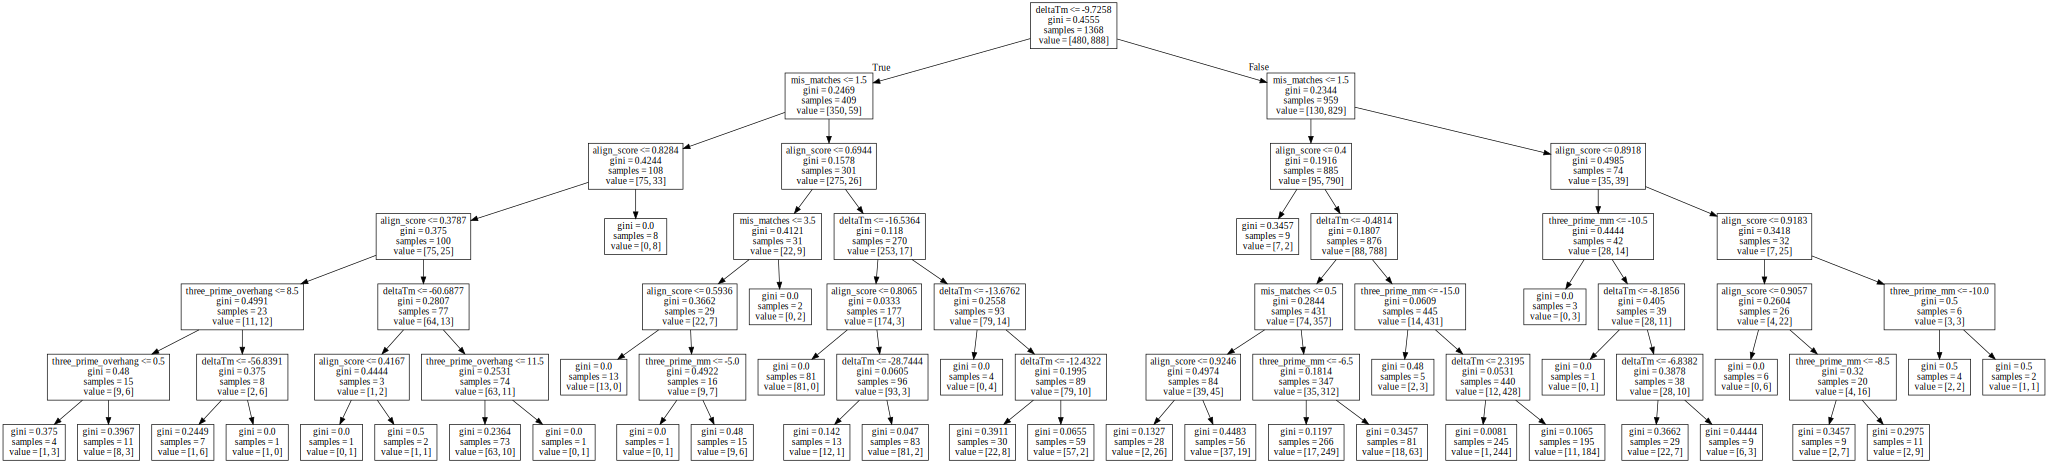

In [627]:
#Plot Decision Tree
from IPython.display import Image
import graphviz 
from sklearn.tree import export_graphviz

dot_data = tree.export_graphviz(clf, out_file=None) 
for i in range(len(attributes)):
    dot_data=dot_data.replace('X[%i]'%i, attributes[i])
graph = graphviz.Source(dot_data) 
graph.render(ud+"PCRPredtree_depth%i"%max_depth) 

export_graphviz(clf, out_file="mytree.dot")
# with open("mytree.dot") as f:
#     dot_data = f.read()
    
for i in range(len(attributes)):
    print('X[%i]  %s'%(i,attributes[i]))
graphviz.Source(dot_data)

## Write New PCRPredict Function

In [625]:
import  joblib
import Probe.MolBio as MB
reload(MB)
reload(SWT)

pcr_predict_model=    joblib.load('/home/ubuntu/git/Genotyper/src/Probe/PCRPredictModel_depth6.joblib')
alt_pcr_predict_model=joblib.load('/home/ubuntu/git/Genotyper/src/Probe/PCRPredictModel_deltaTm_depth6.joblib')
def Compute_pcr_wip(amplicon, for_primer, rev_primer, align_sum_thresh=0.5):
    #Tests to make sure your anti setting is correct
    pcr_wip=SWT.TM.WillItPCR(amplicon, for_primer, rev_primer)
    pcr_wip['flipped_align_delta']=''
    align_sum=pcr_wip['for_align_score']+pcr_wip['rev_align_score']
    if align_sum<align_sum_thresh:
        pcr_wip=SWT.TM.WillItPCR(MB.Antisense(amplicon), for_primer, rev_primer)
        flipped_align_sum=pcr_wip['for_align_score']+pcr_wip['rev_align_score']
        pcr_wip['flipped_align_delta']=flipped_align_sum-align_sum
    return pcr_wip

def PCR_model_Predict(pcr_wip, pcr_predict_model):
    if not('for_Tm' in pcr_wip) or not('rev_Tm' in pcr_wip):
        return 0.0
    for_rev_delta=pcr_wip['for_Tm']-pcr_wip['rev_Tm']
    if for_rev_delta>0:
        fr='rev'
    else:
        fr='for'
    #attributes=['Tm', 'align_score', 'mis_matches', 'three_prime_mm', 'three_prime_overhang']
    attributes=['deltaTm', 'align_score','mis_matches', 'three_prime_mm', 'three_prime_overhang']
    d={}
    for k in attributes:
        d[k]=pcr_wip['%s_%s'%(fr, k)]
    d['three_prime_overhang']= 0 if d['three_prime_overhang']<0 else d['three_prime_overhang']
    d['three_prime_mm']= 0 if not(d['three_prime_mm']) else d['three_prime_mm']
    X=np.array([d[k] for k in attributes]).reshape(1, -1)
    d['predict']=pcr_predict_model.predict_proba(X)
    return d['predict'][0][1]

    
    
def PCRPredict(for_primer, rev_primer, amplicon, sas, 
               pcr_predict_model, 
               attributes=['align_score','mis_matches', 'three_prime_mm', 'three_prime_overhang'], 
               ReturnPassProb=True):
    if sas=='anti':
        amplicon=MB.Antisense(amplicon)
    pcr_wip=Compute_pcr_wip(amplicon, for_primer, rev_primer, align_sum_thresh=0.5)
    if not('for_Tm' in pcr_wip) or not('rev_Tm' in pcr_wip):
        if ReturnPassProb:
            return 0.0
        else:
            return [0,0,0,0] + [0.0]
    for_rev_delta=pcr_wip['for_Tm']-pcr_wip['rev_Tm']
    if for_rev_delta>0:
        fr='rev'
    else:
        fr='for'
    d={}
    for k in attributes:
        d[k]=pcr_wip['%s_%s'%(fr, k)]
    d['three_prime_overhang']= 0 if d['three_prime_overhang']<0 else d['three_prime_overhang']
    d['three_prime_mm']= 0 if not(d['three_prime_mm']) else d['three_prime_mm']
    X=np.array([d[k] for k in attributes]).reshape(1, -1)
    d['predict']=pcr_predict_model.predict_proba(X)
    #d['predict']=clf.predict_proba(X)
    d['pass_prob']=d['predict'][0][1]
    #print('X', X)#, d['predict'])
    if ReturnPassProb:
        return d['pass_prob']
    if pcr_wip['flipped_align_delta']: print('flipped_align_delta', pcr_wip['flipped_align_delta'])
    return [d[k] for k in attributes] + [d['pass_prob']]
    


p=PCRPredict(for_primer, rev_primer, amplicon, 'anti', 
                           pcr_predict_model,
                           attributes=['align_score','mis_matches', 'three_prime_mm', 'three_prime_overhang'],
                           ReturnPassProb=False)
alt_p=PCRPredict(for_primer, rev_primer, amplicon, 'anti', 
                           alt_pcr_predict_model,
                           attributes=['deltaTm', 'align_score','mis_matches', 'three_prime_mm', 'three_prime_overhang'],
                           ReturnPassProb=False)



print(p, alt_p)

[0.4, 2, -5, 0, 0.0] [60.16376375808803, 0.4, 2, -5, 0, 0.33333333333333331]


## Combine/Eval all Models in One Place

In [614]:
#Generate test_data joined to results
X = plot_data[attributes].values
oLst=[];ll=['idx','blast_sim', 'deltaTm', 'minTm', 'Delta', 'align_score','mis_matches', 'three_prime_mm', 'three_prime_overhang', 'pass_proba', 'alt_pass_proba']
for idx, rec in predlab_df.iterrows():
    print('%i %i, %0.2f %s'%(i, rec.idx, rec.Delta, rec.sas), end='\r')
    #print(for_primer, rev_primer)
    #print(amplicon)
    for_primer, rev_primer, amplicon, sas =[rec[k] for k in ['f_primer', 'r_primer', 'amplicon_region', 'sas']]
    pr=PCRPredict(for_primer, rev_primer, amplicon, sas, 
                  pcr_predict_model, 
                  attributes=['align_score','mis_matches', 'three_prime_mm', 'three_prime_overhang'], 
                  ReturnPassProb=False)
    alt_pr=PCRPredict(for_primer, rev_primer, amplicon, sas, 
                  alt_pcr_predict_model, 
                  attributes=['deltaTm', 'align_score','mis_matches', 'three_prime_mm', 'three_prime_overhang'], 
                  ReturnPassProb=True)
    oLst.append([rec.idx, rec.blast_sim, min(rec.for_deltaTm, rec.rev_deltaTm), min(rec.for_Tm, rec.rev_Tm), rec.Delta]+pr+[alt_pr])
    i+=1
    
#attributes=['align_score','mis_matches', 'three_prime_mm', 'three_prime_overhang']
test_data=pd.DataFrame(oLst, columns=ll)
test_data.to_csv(ud+'test_data_join_pred_lab_%s.csv'%tc) 

flipped_align_deltai 0.3993808049535604


In [616]:
test_data

,idx,blast_sim,deltaTm,minTm,Delta,align_score,mis_matches,three_prime_mm,three_prime_overhang,pass_proba,alt_pass_proba
0,367,0.965910,1.834334,56.429959,1.15,1.000000,0,0,0,0.968750,0.995918
1,498,1.000000,2.730479,56.429959,0.07,1.000000,0,0,0,0.968750,0.995918
2,499,1.000000,2.730479,56.429959,0.07,1.000000,0,0,0,0.968750,0.995918
3,567,0.954550,2.730479,56.429959,0.33,1.000000,0,0,0,0.968750,0.995918
4,1132,0.785717,-55.694409,0.388889,9.66,0.444444,2,-3,1,0.000000,0.333333
5,1271,0.809520,-55.638854,0.444444,40.00,0.444444,2,-3,1,0.000000,0.333333
6,1272,0.761907,-54.690482,0.444444,40.00,0.444444,2,-3,1,0.000000,0.333333
7,1340,0.702385,-54.801594,0.333333,15.09,0.333333,3,-4,8,0.000000,0.333333
8,1445,0.989900,1.312762,57.912936,1.01,1.000000,0,0,0,0.968750,0.995918
9,1580,1.000000,2.476477,57.912936,-0.02,1.000000,0,0,0,0.968750,0.995918


## What happens when we use a Rule-of-thumb approach ? 

In [ ]:
align_score	>0.9  0.889
mis_matches	<3
three_prime_mm	<-6
three_prime_overhang

['idx', 'blast_sim', 'deltaTm', 'minTm', 'Delta', 'align_score', 'mis_matches', 
 'three_prime_mm', 'three_prime_overhang', 'pass_proba', 'alt_pass_proba']

In [593]:
test_data.columns

Index(['idx', 'blast_sim', 'deltaTm', 'minTm', 'Delta', 'align_score',
       'mis_matches', 'three_prime_mm', 'three_prime_overhang', 'pass_proba',
       'alt_pass_proba'],
      dtype='object')

In [617]:
def TPFPTNFN_call(d, call):
    TP=FP=TN=FN=0
    if d<5:
        if call:
            TP=1
        else:
            FN=1
    else:
        if call:
            FP=1
        else:
            TN=1
    return np.array([TP,FP,TN,FN])

lst=[
    ['blast_sim<0.95', {'blast_sim':lambda x:x<0.95}],
    ['blast_sim<0.9', {'blast_sim':lambda x:x<0.9}],
    ['blast_sim<0.8', {'blast_sim':lambda x:x<0.8}],
    ['blast_sim<0.7', {'blast_sim':lambda x:x<0.7}],
    ['align<0.9', {'align_score':lambda x:x<0.9}],
    ['align<0.8', {'align_score':lambda x:x<0.8}],
    ['mis_matches>3', {'mis_matches':lambda x:x>3}],
    ['three_prime_mm>-6', {'three_prime_mm':lambda x:x>-6}],
    ['three_prime_overhang>1', {'three_prime_overhang':lambda x:x>1}],
    ['at', {'align_score':lambda x:x<0.8,
              'three_prime_overhang':lambda x:x>1}],
    ['amtt', {'align_score':lambda x:x<0.8,
              'mis_matches':lambda x:x>3, 
              'three_prime_mm':lambda x:x>-6, 
              'three_prime_overhang':lambda x:x>1}],
    ['minTm<55', {'minTm':lambda x:x<55.0}],
    ['minTm<52', {'minTm':lambda x:x<52.0}],
    ['minTm<50', {'minTm':lambda x:x<50.0}],
    ['minTm<45', {'minTm':lambda x:x<45.0}],
    ['minTm<40', {'minTm':lambda x:x<40.0}],
    ['deltaTm<0', {'deltaTm':lambda x:x<0}],
    ['deltaTm<-5', {'deltaTm':lambda x:x<-5}],
    ['deltaTm<-10', {'deltaTm':lambda x:x<-10}],
    ['pass_proba<0.9', {'pass_proba':lambda x:x<0.9}],
    ['pass_proba<0.8', {'pass_proba':lambda x:x<0.8}],
    ['pass_proba<0.8|three_prime_overhang', {'pass_proba':lambda x:x<0.8,
                                            'three_prime_overhang':lambda x:x>2}],
    ['alt_pass_proba<0.9', {'alt_pass_proba':lambda x:x<0.9}],
    ['alt_pass_proba<0.8', {'alt_pass_proba':lambda x:x<0.8}],
    

]
oLst=[];LL=['test_name', 'test_dict', 'TP','FP','TN','FN', 'tpr', 'fpr']
for trial in lst:
    test_name, lam_dict=trial
    confusion=np.array([0,0,0,0])
    for idx, rec in test_data.iterrows():
        result=True
        for key, lam in lam_dict.items():
            if lam(rec[key]):
                result=False
        if result:
            confusion=confusion+TPFPTNFN_call(rec.Delta, 1)
        else:
            confusion=confusion+TPFPTNFN_call(rec.Delta, 0)
    fpr=confusion[1]/(confusion[1]+confusion[2])
    tpr=confusion[0]/(confusion[0]+confusion[3])
    #print(test_name, confusion, 'tpr: %0.2f fpr: %0.2f'%(tpr, fpr))
    oLst.append([test_name, '|'.join(list(lam_dict.keys()))]+list(confusion)+[tpr, fpr])
test_hand_coded=pd.DataFrame(oLst, columns=LL)
test_hand_coded.to_csv(ud+'test_hand_coded_%s.csv'%tc) 
test_hand_coded

,test_name,test_dict,TP,FP,TN,FN,tpr,fpr
0,blast_sim<0.95,blast_sim,594,106,374,294,0.668919,0.220833
1,blast_sim<0.9,blast_sim,842,276,204,46,0.948198,0.575000
2,blast_sim<0.8,blast_sim,857,341,139,31,0.965090,0.710417
3,blast_sim<0.7,blast_sim,867,407,73,21,0.976351,0.847917
4,align<0.9,align_score,746,95,385,142,0.840090,0.197917
5,align<0.8,align_score,849,319,161,39,0.956081,0.664583
6,mis_matches>3,mis_matches,886,456,24,2,0.997748,0.950000
7,three_prime_mm>-6,three_prime_mm,371,180,300,517,0.417793,0.375000
8,three_prime_overhang>1,three_prime_overhang,869,420,60,19,0.978604,0.875000
9,at,three_prime_overhang|align_score,849,314,166,39,0.956081,0.654167


## Now Let's compute ROC Curve for final assay:

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

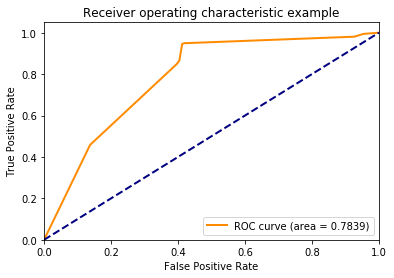

In [596]:
#ROC  https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#
inLst=[list(x) for x in list(test_data[['Delta', 'alt_pass_proba']].values)]
inLst.sort(key=lambda x:x[1])
TF=lambda x:x<5
def TPFPTNFN(d, prob, probability_threshold=0.5):
    TP=FP=TN=FN=0
    if d<5:
        if prob>probability_threshold:
            TP=1
        else:
            FN=1
    else:
        if prob>probability_threshold:
            FP=1
        else:
            TN=1
    return np.array([TP,FP,TN,FN])

fpr=[1];tpr=[1]
for i in range(1,100,1):
    PT=i/100.0
    confusion=np.array([0,0,0,0])
    for d,prob in inLst:
        confusion=confusion+TPFPTNFN(d, prob, probability_threshold=PT)
    fpr.append(confusion[1]/(confusion[1]+confusion[2]))
    #TPR=TP/(TP+FN)
    tpr.append(confusion[0]/(confusion[0]+confusion[3]))
    print('%0.2f, TPFPTNFN:%s  fpr:%0.2f tpr:%0.2f'%(PT, str(confusion), fpr[-1], tpr[-1]), end='\r')

fpr.append(0)
tpr.append(0)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Try a Commercial AutoML Framework that looks at multiple Models:

In [365]:
#http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
import h2o
from h2o.automl import H2OAutoML#, get_leaderboard
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 min 22 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,9 months and 5 days !!!
H2O cluster name:,H2O_from_python_ubuntu_91sts1
H2O cluster total nodes:,1
H2O cluster free memory:,25.74 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"locked, healthy"


In [379]:
test_data.columns#to_csv(ud+'test_data_join_pred_lab_20200210.csv') 

Index(['idx', 'Delta', 'align_score', 'mis_matches', 'three_prime_mm',
       'three_prime_overhang', 'pass_proba'],
      dtype='object')

In [391]:
test_data['response']=0
#test_data['response'][test_data['Delta']<10]=1
test_data['response'][test_data['Delta']<5]=2
hdata=test_data[['response', 'align_score', 'mis_matches', 'three_prime_mm','three_prime_overhang']]
df = hdata.sample(frac=1).reset_index(drop=True)
hdata_train=df.loc[0:1100,:]
hdata_test=df.loc[1100:,:]

hdata_train.to_csv(ud+'hdata_train.csv')
hdata_test.to_csv(ud+'hdata_test.csv')

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [392]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file(ud+'hdata_train.csv')
test = h2o.import_file(ud+'hdata_test.csv')

# Identify predictors and response
x = train.columns
y = "response"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# AutoML Leaderboard
lb = aml.leaderboard

# Optionally edd extra model information to the leaderboard
#lb = aml.get_leaderboard(aml, extra_columns='ALL')

# Print all rows (instead of default 10 rows)
lb.head(rows=lb.nrows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_2_AutoML_20200213_012651,0.928477,0.311369,0.119231,0.300073,0.0900435
GBM_1_AutoML_20200213_012651,0.927926,0.322854,0.124649,0.307485,0.0945472
XGBoost_3_AutoML_20200213_012651,0.927119,0.308088,0.107526,0.298051,0.0888344
StackedEnsemble_AllModels_AutoML_20200213_012651,0.9271,0.306097,0.110363,0.297388,0.0884398
StackedEnsemble_BestOfFamily_AutoML_20200213_012651,0.926575,0.306448,0.108994,0.297566,0.0885453
GBM_4_AutoML_20200213_012651,0.925818,0.320872,0.120621,0.305102,0.0930872
GBM_3_AutoML_20200213_012651,0.924923,0.318199,0.115581,0.302437,0.0914683
XGBoost_grid_1_AutoML_20200213_012651_model_4,0.924005,0.313689,0.107169,0.30206,0.0912403
XGBoost_grid_1_AutoML_20200213_012651_model_1,0.922422,0.321208,0.105701,0.303639,0.0921968
XGBoost_grid_1_AutoML_20200213_012651_model_2,0.921698,0.343218,0.119808,0.312804,0.0978461


## Write Final Function that goes into production:

In [67]:
ud="/tdata1/enterobase_20190205/"
predlab_df=pd.read_csv(ud+'join_pred_lab_20200209.csv')

In [351]:
def PCRPredictRunner(x):
    return PCRPredict(x['f_primer'], x['r_primer'], x['amplicon_region'], x['sas'])

predlab_df['pass_prob']=predlab_df[["f_primer", "r_primer", "amplicon_region", "sas"]].apply(PCRPredictRunner, axis=1)
predlab_df.to_csv(ud+'join_pred_lab_%s.csv'%tc)